In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-wheat-detection/sample_submission.csv
/kaggle/input/global-wheat-detection/train.csv
/kaggle/input/global-wheat-detection/test/796707dd7.jpg
/kaggle/input/global-wheat-detection/test/2fd875eaa.jpg
/kaggle/input/global-wheat-detection/test/cc3532ff6.jpg
/kaggle/input/global-wheat-detection/test/53f253011.jpg
/kaggle/input/global-wheat-detection/test/f5a1f0358.jpg
/kaggle/input/global-wheat-detection/test/51f1be19e.jpg
/kaggle/input/global-wheat-detection/test/aac893a91.jpg
/kaggle/input/global-wheat-detection/test/cb8d261a3.jpg
/kaggle/input/global-wheat-detection/test/51b3e36ab.jpg
/kaggle/input/global-wheat-detection/test/348a992bb.jpg
/kaggle/input/global-wheat-detection/train/944c60a15.jpg
/kaggle/input/global-wheat-detection/train/dd5dd0234.jpg
/kaggle/input/global-wheat-detection/train/72f8aaa4f.jpg
/kaggle/input/global-wheat-detection/train/69595016d.jpg
/kaggle/input/global-wheat-detection/train/28b8ba0aa.jpg
/kaggle/input/global-wheat-detection/train/2d6357

In [2]:
!pip install torch torchvision

In [33]:
# Standard library imports
import os  # For handling file paths
import random  # For generating random numbers
from collections import Counter  # For counting hashable objects

# Third-party imports
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from PIL import Image, ImageDraw  # For image handling and drawing
import matplotlib.pyplot as plt  # For plotting
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets

# PyTorch imports
import torch  # For tensor operations and neural networks
import torchvision  # For computer vision tasks

# Torchvision imports
from torchvision import transforms as T  # For data transformations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # For Faster R-CNN model


In [34]:
train = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [35]:
coord = pd.DataFrame(list(train.bbox.apply(lambda x : x[1:-1].split(",")).values),columns=["x1","y1","w","h"])

In [36]:
coord


x1      y1       w       h
0       834.0   222.0    56.0    36.0
1       226.0   548.0   130.0    58.0
2       377.0   504.0    74.0   160.0
3       834.0    95.0   109.0   107.0
4        26.0   144.0   124.0   117.0
...       ...     ...     ...     ...
147788   64.0   619.0    84.0    95.0
147789  292.0   549.0   107.0    82.0
147790  134.0   228.0   141.0    71.0
147791  430.0    13.0   184.0    79.0
147792  875.0   740.0    94.0    61.0

[147793 rows x 4 columns]

In [37]:
df = pd.concat([train,coord],axis=1)

In [38]:
df

image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

           x1      y1       w       h  
0       834.0   222.0    56.0    36.0  
1       226.0   548.0   130.0    58.0  
2       377.0   504.0    74.0   160.0  
3       834.0    95.0   109.0   107.0  
4        26.0   144.0   124.0   117.0  
...       ...     ...     ...     ...  
147788   64.0   619.0    84.0    95.0  
147789  292.0   549.0   107.0    82.0  
147790  134.0   228.0   141.0    71.0  
147791  430.0    13.0   184.0    79.0  
147792  875.0   740.0    94.0    61.0  

[147793 rows x 9 columns]

In [39]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])

In [40]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']

In [41]:
df.drop(['bbox','width','height','w','h','source'],axis=1,inplace=True)

In [42]:
unique_imgs=df.image_id.unique()
len(unique_imgs)

3373

In [43]:
# Define a custom dataset class inheriting from torch.utils.data.Dataset
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        """
        Initialize the dataset with a DataFrame, a list of unique image names, and indices.
        
        Args:
            df (pd.DataFrame): DataFrame containing image IDs and bounding box information.
            unique_imgs (list): List of unique image names.
            indices (list): List of indices to be used for accessing the dataset.
        """
        self.df = df  # DataFrame containing image and bounding box data
        self.unique_imgs = unique_imgs  # List of unique image names
        self.indices = indices  # Indices for accessing the images in the dataset
    
    def __len__(self):
        """
        Return the length of the dataset.
        
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.indices)  # Length of the dataset based on the indices
    
    def __getitem__(self, idx):
        """
        Get an item from the dataset at the specified index.
        
        Args:
            idx (int): Index of the item to be fetched.
        
        Returns:
            tuple: Tuple containing the image tensor and the target dictionary.
        """
        # Get the image name using the index
        image_name = self.unique_imgs[self.indices[idx]]
        
        # Get the bounding boxes for the image
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")
        
        # Open the image and convert it to RGB format
        img = Image.open("../input/global-wheat-detection/train/" + image_name + ".jpg").convert('RGB')
        
        # Create labels tensor with value 1 for each bounding box
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        
        # Create the target dictionary containing boxes and labels
        target = {}
        target["boxes"] = torch.tensor(boxes)  # Bounding boxes as a tensor
        target["label"] = labels  # Labels as a tensor
        
        # Return the image converted to a tensor and the target dictionary
        return T.ToTensor()(img), target


In [44]:
train_inds , val_inds =train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [45]:
def custom_collate(data):
    return data

Need for custom_collate in Object Detection
Handling Variable Number of Annotations:

In object detection, each image can have a different number of objects, and consequently, a different number of annotations (bounding boxes). The default collate function in PyTorch (default_collate) expects each sample in the batch to have the same shape, which is not the case here.
Maintaining Data Structure:

The custom_collate function helps maintain the structure of the data when it is batched together. Specifically, it returns the data as a list of tuples, where each tuple contains an image tensor and its corresponding target dictionary. This structure is essential for the Faster R-CNN model, which expects a list of such tuples as input.
Avoiding Collate Errors:

Without a custom collate function, the DataLoader might try to convert the list of dictionaries (targets) into a single tensor, which would fail due to the variable number of bounding boxes per image.

Input: data is a list of tuples. Each tuple contains:

An image tensor (e.g., T.ToTensor()(img)).
A target dictionary (e.g., target with keys "boxes" and "labels").
Output: The same list of tuples is returned without any modification.

In [57]:
train_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds),
                                       batch_size=5,
                                       shuffle=True,
                                       collate_fn=custom_collate,
                                       pin_memory=True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds),
                                     batch_size=5,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False)

In [58]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")


In [59]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [60]:
num_classes=2

In [61]:
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [63]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=50

In [64]:
from tqdm import tqdm
import numpy as np
import torch

# Move the model to the specified device (CPU or GPU)
model.to(device)

# -------------------------------
# Early stopping parameters
# -------------------------------
patience = 3
best_loss = np.inf
patience_counter = 0

# Loop over the number of epochs
for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize the loss for the current epoch
    
    # Progress bar for training dataloader
    pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    
    # Loop over the data in the training DataLoader
    for data in pbar:
        imgs = []      # List to store the images
        targets = []   # List to store the target dictionaries
        
        # Loop over each data sample in the batch
        for d in data:
            # Append the image tensor to the imgs list and move it to the device
            imgs.append(d[0].to(device))
            
            # Create a target dictionary for the current sample
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['label'].to(device)
            
            targets.append(targ)
        
        # Forward pass → loss dictionary
        loss_dict = model(imgs, targets)
        
        # Total loss
        loss = sum(v for v in loss_dict.values())
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        pbar.set_postfix(loss=loss.item())
    
    # -------------------------------
    # Epoch end
    # -------------------------------
    print(f"Epoch {epoch+1} | Total Loss: {epoch_loss:.4f}")
    
    # -------------------------------
    # Early stopping logic
    # -------------------------------
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        
        # Save best model
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Improvement — model saved")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            print("🛑 Early stopping triggered")
            break


Epoch 1/50: 100%|██████████| 607/607 [09:11<00:00,  1.10it/s, loss=0.919]


Epoch 1 | Total Loss: 595.9850
✅ Improvement — model saved


Epoch 2/50: 100%|██████████| 607/607 [08:36<00:00,  1.17it/s, loss=0.682]


Epoch 2 | Total Loss: 480.3644
✅ Improvement — model saved


Epoch 3/50: 100%|██████████| 607/607 [08:36<00:00,  1.17it/s, loss=0.692]


Epoch 3 | Total Loss: 459.1720
✅ Improvement — model saved


Epoch 4/50: 100%|██████████| 607/607 [08:49<00:00,  1.15it/s, loss=0.752]


Epoch 4 | Total Loss: 444.5544
✅ Improvement — model saved


Epoch 5/50: 100%|██████████| 607/607 [08:39<00:00,  1.17it/s, loss=0.617]


Epoch 5 | Total Loss: 433.1457
✅ Improvement — model saved


Epoch 6/50: 100%|██████████| 607/607 [08:36<00:00,  1.17it/s, loss=0.597]


Epoch 6 | Total Loss: 420.8239
✅ Improvement — model saved


Epoch 7/50: 100%|██████████| 607/607 [08:37<00:00,  1.17it/s, loss=0.641]


Epoch 7 | Total Loss: 410.4781
✅ Improvement — model saved


Epoch 8/50: 100%|██████████| 607/607 [08:38<00:00,  1.17it/s, loss=0.621]


Epoch 8 | Total Loss: 401.9760
✅ Improvement — model saved


Epoch 9/50: 100%|██████████| 607/607 [08:36<00:00,  1.17it/s, loss=0.571]


Epoch 9 | Total Loss: 392.7926
✅ Improvement — model saved


Epoch 10/50: 100%|██████████| 607/607 [08:39<00:00,  1.17it/s, loss=0.545]


Epoch 10 | Total Loss: 382.4956
✅ Improvement — model saved


Epoch 11/50: 100%|██████████| 607/607 [08:41<00:00,  1.16it/s, loss=0.662]


Epoch 11 | Total Loss: 373.0069
✅ Improvement — model saved


Epoch 12/50: 100%|██████████| 607/607 [08:39<00:00,  1.17it/s, loss=0.503]


Epoch 12 | Total Loss: 363.7701
✅ Improvement — model saved


Epoch 13/50: 100%|██████████| 607/607 [08:38<00:00,  1.17it/s, loss=0.532]


Epoch 13 | Total Loss: 353.3305
✅ Improvement — model saved


Epoch 14/50: 100%|██████████| 607/607 [08:37<00:00,  1.17it/s, loss=0.531]


Epoch 14 | Total Loss: 344.3635
✅ Improvement — model saved


Epoch 15/50: 100%|██████████| 607/607 [08:36<00:00,  1.17it/s, loss=0.536]


Epoch 15 | Total Loss: 336.2988
✅ Improvement — model saved


Epoch 16/50: 100%|██████████| 607/607 [08:40<00:00,  1.17it/s, loss=0.583]


Epoch 16 | Total Loss: 329.2985
✅ Improvement — model saved


Epoch 17/50: 100%|██████████| 607/607 [08:39<00:00,  1.17it/s, loss=0.445]


Epoch 17 | Total Loss: 319.2071
✅ Improvement — model saved


Epoch 18/50:  86%|████████▌ | 520/607 [07:34<01:16,  1.14it/s, loss=0.465]


KeyboardInterrupt: 

In [ ]:


#gc.collect()
#torch.cuda.empty_cache()


In [65]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [66]:

data = iter(val_dl).__next__()

In [67]:
data

[[tensor([[[0.5686, 0.5843, 0.6078,  ..., 0.5098, 0.5647, 0.5569],
           [0.5804, 0.5882, 0.6078,  ..., 0.5176, 0.5725, 0.5686],
           [0.5922, 0.6000, 0.6078,  ..., 0.5216, 0.5882, 0.5843],
           ...,
           [0.1176, 0.1176, 0.1137,  ..., 0.0667, 0.0627, 0.0627],
           [0.1216, 0.1216, 0.1216,  ..., 0.0706, 0.0667, 0.0667],
           [0.1216, 0.1255, 0.1255,  ..., 0.0745, 0.0706, 0.0706]],
  
          [[0.4196, 0.4353, 0.4588,  ..., 0.3843, 0.4353, 0.4275],
           [0.4314, 0.4392, 0.4588,  ..., 0.3922, 0.4431, 0.4392],
           [0.4431, 0.4510, 0.4588,  ..., 0.3961, 0.4549, 0.4510],
           ...,
           [0.0784, 0.0784, 0.0745,  ..., 0.0667, 0.0627, 0.0627],
           [0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0667, 0.0667],
           [0.0824, 0.0863, 0.0863,  ..., 0.0745, 0.0706, 0.0706]],
  
          [[0.2745, 0.2902, 0.3137,  ..., 0.2314, 0.2745, 0.2667],
           [0.2863, 0.2941, 0.3137,  ..., 0.2392, 0.2824, 0.2784],
           [0.2980, 0.

In [68]:
img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

In [69]:
output = model([img.to(device)])

In [70]:
output

[{'boxes': tensor([[ 701.2495,  902.0939,  900.6965, 1023.6783],
          [ 381.2921,  877.6271,  521.3107,  993.8755],
          [ 609.9838,  486.9765,  756.9860,  667.0572],
          [ 552.8950,  804.6456,  682.7634,  922.0433],
          [ 693.5453,  846.8182,  833.3927,  955.8329],
          [ 706.7220,  577.4948,  888.5807,  688.6650],
          [ 455.3990,  300.2824,  549.2028,  413.8340],
          [ 514.3088,  686.7834,  605.6287,  816.4016],
          [ 586.8586,  976.0642,  675.5837, 1023.8718],
          [ 663.5883,  289.7058,  804.1115,  414.5955],
          [ 503.7915,  363.4099,  649.2317,  472.0659],
          [ 505.8372,  664.8477,  601.8949,  743.6868],
          [ 418.5740,  425.5813,  451.4031,  493.1421],
          [ 314.9743,  976.2082,  442.5978, 1024.0000],
          [ 475.8999,  323.5276,  625.3690,  462.9828],
          [ 572.3125,  342.1750,  661.3373,  412.2611]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 

In [71]:
out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

In [72]:
keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

In [73]:
out_bbox.shape , keep.shape

(torch.Size([16, 4]), torch.Size([15]))

In [74]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[145, 107,  70],
        [149, 111,  74],
        [155, 117,  80],
        ...,
        [130,  98,  59],
        [144, 111,  70],
        [142, 109,  68]],

       [[148, 110,  73],
        [150, 112,  75],
        [155, 117,  80],
        ...,
        [132, 100,  61],
        [146, 113,  72],
        [145, 112,  71]],

       [[151, 113,  76],
        [153, 115,  78],
        [155, 117,  80],
        ...,
        [133, 101,  62],
        [150, 116,  78],
        [149, 115,  77]],

       ...,

       [[ 30,  20,  10],
        [ 30,  20,  10],
        [ 29,  19,   9],
        ...,
        [ 17,  17,   9],
        [ 16,  16,   8],
        [ 16,  16,   8]],

       [[ 31,  21,  11],
        [ 31,  21,  11],
        [ 31,  21,  11],
        ...,
        [ 18,  18,  10],
        [ 17,  17,   9],
        [ 17,  17,   9]],

       [[ 31,  21,  11],
        [ 32,  22,  12],
        [ 32,  22,  12],
        ...,
        [ 19,  19,  11],
        [ 18,  18,  10],
        [ 18,  18,  10]]

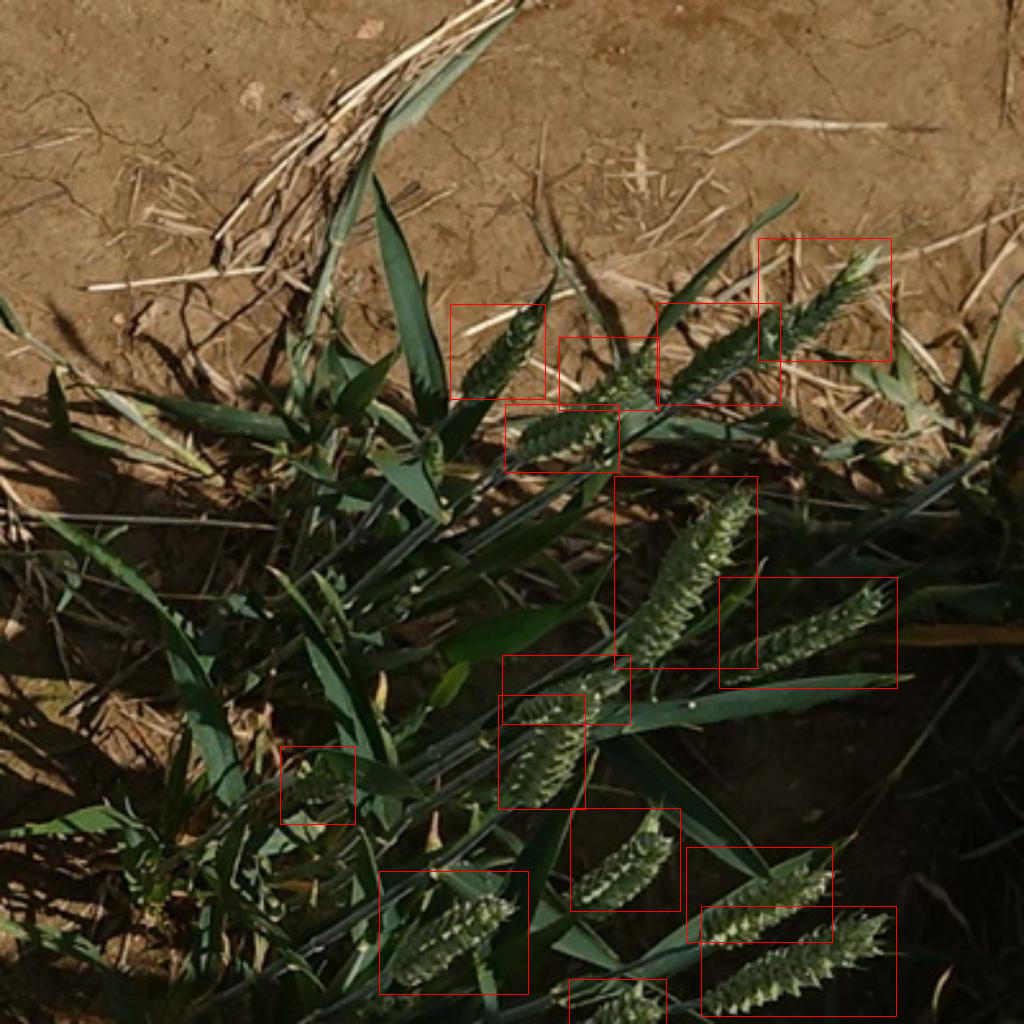

In [75]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [76]:
# Save the model state
torch.save(model.state_dict(), 'modified_fasterrcnn_resnet50_fpn.pth')

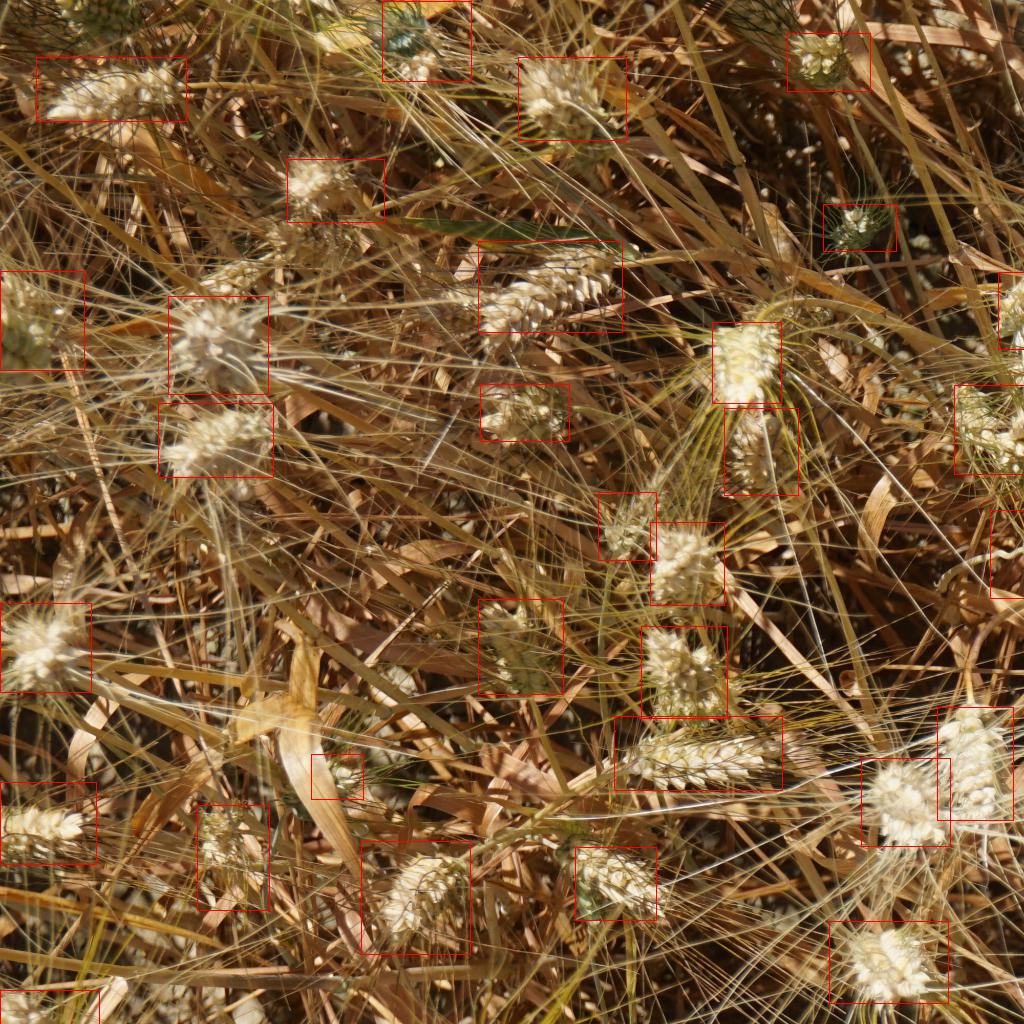

In [77]:
model.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

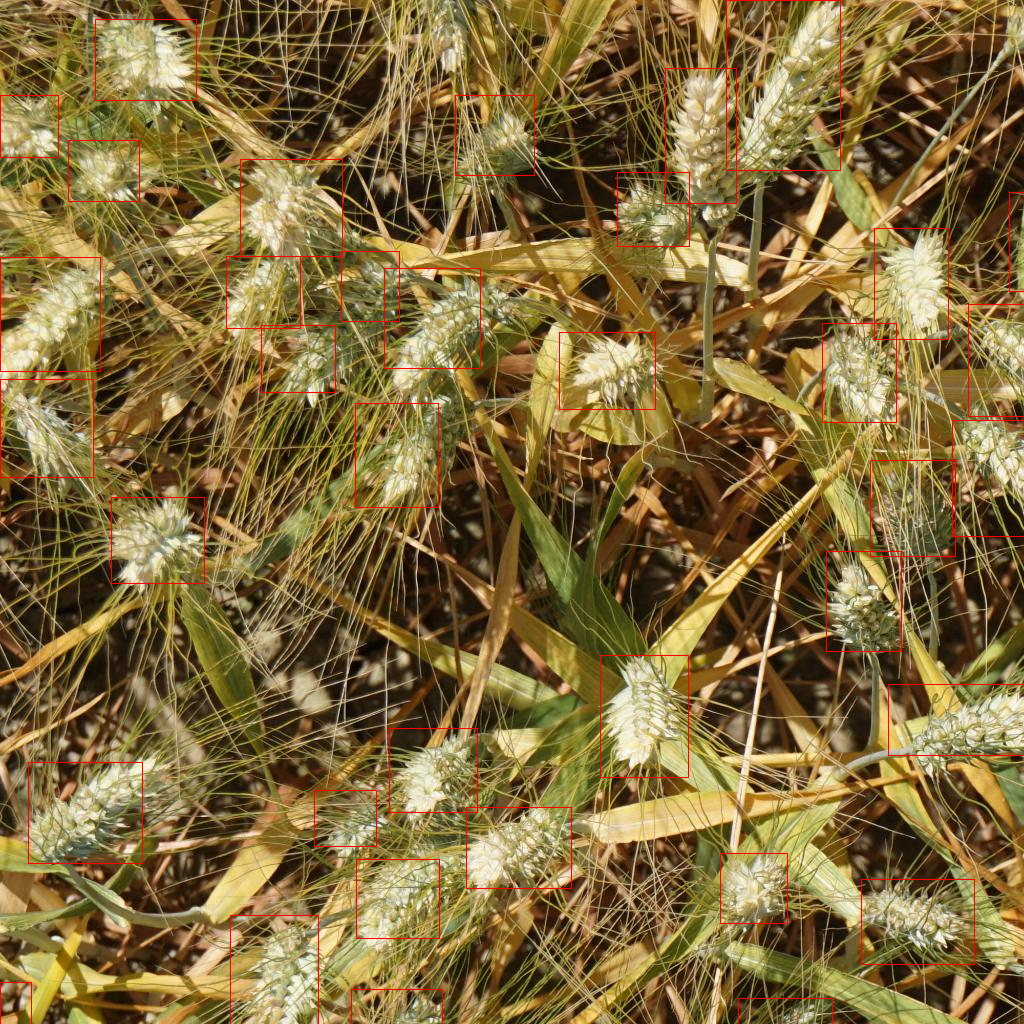

In [78]:
model.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [3]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# -------------------------------
# Model creation (MUST match training)
# -------------------------------
def create_model(num_classes):
    model = fasterrcnn_resnet50_fpn_v2(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# -------------------------------
# Setup
# -------------------------------
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Create model
# -------------------------------
model = create_model(num_classes)

# -------------------------------
# Load weights from Kaggle input
# -------------------------------
checkpoint_path = "/kaggle/input/best/other/default/1/best_model_wheat.pth"

state_dict = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state_dict)

# -------------------------------
# Move to device
# -------------------------------
model.to(device)

# -------------------------------
# Set mode
# -------------------------------
model.eval()   # use .train() if continuing training

print("✅ Model loaded successfully")


✅ Model loaded successfully


In [79]:
from tqdm import tqdm
import torch

all_preds = []
all_targets = []

with torch.no_grad():
    for data in tqdm(val_dl, desc="Validation"):
        imgs = []
        targets = []

        for d in data:
            # d[0] -> image
            # d[1] -> target dict
            imgs.append(d[0].to(device))
            targets.append({
                "boxes": d[1]["boxes"].to(device),
                "labels": d[1]["label"].to(device)
            })

        # Forward pass (no targets in eval)
        outputs = model(imgs)

        all_preds.extend(outputs)
        all_targets.extend(targets)


Validation: 100%|██████████| 68/68 [00:40<00:00,  1.67it/s]


In [80]:
!pip install torchmetrics


In [81]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision(iou_type="bbox")

metric.update(all_preds, all_targets)
results = metric.compute()


In [82]:
print(f"mAP@0.5: {results['map_50']:.4f}")
print(f"mAP@0.5:0.95: {results['map']:.4f}")
print(f"Mean Recall (100 dets): {results['mar_100']:.4f}")


mAP@0.5: 0.8915
mAP@0.5:0.95: 0.4721
Mean Recall (100 dets): 0.5395


In [83]:
print("Per-class AP:", results["map_per_class"])


Per-class AP: tensor(-1.)


In [84]:
from sklearn.metrics import roc_auc_score

y_true = []
y_score = []

for preds, gts in zip(all_preds, all_targets):
    y_true.append(1 if len(gts["boxes"]) > 0 else 0)
    y_score.append(preds["scores"].max().item() if len(preds["scores"]) > 0 else 0.0)

auc = roc_auc_score(y_true, y_score)
print("Image-level AUC:", auc)


Image-level AUC: nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [85]:
## making video


In [86]:
import cv2
import torch
import numpy as np

def draw_boxes(frame, boxes, scores, score_thr=0.3):
    for box, score in zip(boxes, scores):
        if score < score_thr:
            continue
        x1, y1, x2, y2 = box.int().tolist()
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(frame, f"{score:.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    return frame


In [87]:
def tensor_to_cv(img_tensor):
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    return img


In [90]:
def tensor_to_cv(img_tensor):
    img = img_tensor.detach().cpu()
    img = img.permute(1, 2, 0).contiguous().numpy()  # 🔑 contiguous
    img = (img * 255).astype(np.uint8)
    return img


In [91]:
import cv2
import torch
import numpy as np
from tqdm import tqdm

model.eval()

# ---- Infer frame size safely ----
data_iter = iter(train_dl)
first_batch = next(data_iter)
first_img = tensor_to_cv(first_batch[0][0])
IMG_HEIGHT, IMG_WIDTH = first_img.shape[:2]

out = cv2.VideoWriter(
    "train_predictions.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    10,
    (IMG_WIDTH, IMG_HEIGHT)
)

with torch.no_grad():
    for data in tqdm(train_dl, desc="Train Video"):
        for d in data:
            img_tensor = d[0].to(device)
            img_cv = tensor_to_cv(d[0])

            preds = model([img_tensor])[0]

            for box, score in zip(preds["boxes"], preds["scores"]):
                if score < 0.3:
                    continue
                x1, y1, x2, y2 = map(int, box.tolist())
                cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)

            out.write(img_cv)

out.release()
print("✅ Train video saved correctly")


Train Video: 100%|██████████| 607/607 [07:22<00:00,  1.37it/s]

✅ Train video saved correctly


In [92]:
import cv2
import torch
import numpy as np
from tqdm import tqdm

# ---------- helper ----------
def tensor_to_cv(img_tensor):
    img = img_tensor.detach().cpu()
    img = img.permute(1, 2, 0).contiguous().numpy()  # 🔑 contiguous
    img = (img * 255).astype(np.uint8)
    return img


model.eval()

# ---------- infer frame size from first val batch ----------
val_iter = iter(val_dl)
first_batch = next(val_iter)
first_img_cv = tensor_to_cv(first_batch[0][0])

IMG_HEIGHT, IMG_WIDTH = first_img_cv.shape[:2]

# ---------- video writer ----------
out = cv2.VideoWriter(
    "val_predictions.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),  # fallback: *"XVID"
    10,
    (IMG_WIDTH, IMG_HEIGHT)
)

# ---------- inference + drawing ----------
with torch.no_grad():
    for data in tqdm(val_dl, desc="Validation Video"):
        for d in data:
            img_tensor = d[0].to(device)
            img_cv = tensor_to_cv(d[0])

            preds = model([img_tensor])[0]

            for box, score in zip(preds["boxes"], preds["scores"]):
                if score < 0.3:
                    continue
                x1, y1, x2, y2 = map(int, box.tolist())
                cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    img_cv, f"{score:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1
                )

            out.write(img_cv)

out.release()
print("✅ Validation video saved: val_predictions.mp4")


Validation Video: 100%|██████████| 68/68 [00:48<00:00,  1.40it/s]

✅ Validation video saved: val_predictions.mp4


In [4]:
# test data

In [5]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm


In [6]:
def tensor_to_cv(img_tensor):
    img = img_tensor.detach().cpu()
    img = img.permute(1, 2, 0).contiguous().numpy()
    img = (img * 255).astype(np.uint8)
    return img


In [7]:
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [8]:
TEST_DIR = "/kaggle/input/global-wheat-detection/test"
test_images = sorted(os.listdir(TEST_DIR))


In [9]:
first_img = cv2.imread(os.path.join(TEST_DIR, test_images[0]))
IMG_HEIGHT, IMG_WIDTH = first_img.shape[:2]


In [10]:
out = cv2.VideoWriter(
    "test_predictions.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    10,
    (IMG_WIDTH, IMG_HEIGHT)
)


In [11]:
from torchvision import transforms as T

transform = T.Compose([
    T.ToTensor()
])

with torch.no_grad():
    for img_name in tqdm(test_images, desc="Test Video"):
        img_path = os.path.join(TEST_DIR, img_name)

        # Read image
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # To tensor
        img_tensor = transform(img_rgb).to(device)

        # Predict
        preds = model([img_tensor])[0]

        # Draw boxes
        for box, score in zip(preds["boxes"], preds["scores"]):
            if score < 0.3:   # tune this threshold
                continue

            x1, y1, x2, y2 = map(int, box.tolist())
            cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                img_bgr, f"{score:.2f}",
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 1
            )

        # Write frame
        out.write(img_bgr)


Test Video: 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


In [12]:
out.release()
print("✅ Test prediction video saved: test_predictions.mp4")


✅ Test prediction video saved: test_predictions.mp4
